# Scientific Computing with Python (Second Edition)

## Chapter 19: Comprehensive Examples

*We start by importing all from Numpy. As explained in Chapter 01 the examples are written assuming this import is initially done.*


In [1]:
from numpy import *

### 19.1 Polynomials
*Here we give the complete code, which was developped step-wise in the book Section 19.1*
#### 19.1.3 The polynomial class


In [2]:
import scipy.linalg as sl
import matplotlib.pyplot as mp

class PolyNomial:
    base='monomial'
    def __init__(self,**args):
        if 'points' in args:
            self.points = array(args['points'])
            self.xi = self.points[:,0]
            self.coeff = self.point_2_coeff()
            self.degree = len(self.coeff)-1
        elif 'coeff' in args:
            self.coeff = array(args['coeff'])
            self.degree = len(self.coeff)-1
            self.points = self.coeff_2_point()
        else:
            self.points = array([[0,0]])
            self.xi = array([1.])
            self.coeff = self.point_2_coeff()
            self.degree = 0
    def point_2_coeff(self):
        return sl.solve(vander(self.x),self.y)
    def coeff_2_point(self):
        points = [[x,self(x)] for x in linspace(0,1,self.degree+1)]
        return array(points)
    def __call__(self,x):
        return polyval(self.coeff,x)
    @property
    def x(self):
        return self.points[:,0]
    @property
    def y(self):
        return self.points[:,1]
    def __repr__(self):
        txt  = f'Polynomial of degree {self.degree} \n'
        txt += f'with coefficients {self.coeff} \n in {self.base} basis.'
        return txt
    margin = .05
    plotres = 500
    def plot(self,ab=None,plotinterp=True):
        if ab is None: # guess a and b
           x = self.x
           a, b = x.min(), x.max()
           h = b-a
           a -= self.margin*h
           b += self.margin*h
        else:
           a,b = ab
        x = linspace(a,b,self.plotres)
        y = vectorize(self.__call__)(x)
        mp.plot(x,y)
        mp.xlabel('$x$')
        mp.ylabel('$p(x)$')
        if plotinterp:
            mp.plot(self.x, self.y, 'ro')
    def companion(self):
        companion = eye(self.degree, k=-1)
        companion[0,:] -= self.coeff[1:]/self.coeff[0]
        return companion
    def zeros(self):
        companion = self.companion()
        return sl.eigvals(companion)


#### 19.1.4 Usage examples of the polynomial class


In [3]:
p = PolyNomial(points=[(1,0),(2,3),(3,8)])

In [4]:
p.coeff

array([ 1.0000000e+00,  8.8817842e-16, -1.0000000e+00])

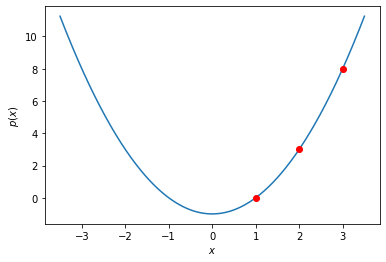

In [5]:
p.plot((-3.5,3.5))

In [6]:
pz = p.zeros()
print(pz)

[-1.+0.j  1.+0.j]


#### 19.1.5 Newton polynomial
*Again we present here the entire class directly and not the step-wise development as given in the text*

In [7]:
class NewtonPolynomial(PolyNomial):
    base = 'Newton'
    def __init__(self,**args):
        if 'coeff' in args:
            try:
                self.xi = array(args['xi'])
            except KeyError: 
                raise ValueError('Coefficients need to be given'
                'together with abscissae values xi')
        super(NewtonPolynomial, self).__init__(**args)
    def point_2_coeff(self):
        return array(list(self.divdiff()))
    def divdiff(self): 
        xi = self.xi
        row = self.y
        yield row[0]
        for level in range(1,len(xi)):
            row = (row[1:] - row[:-1])/(xi[level:] - xi[:-level])
            if allclose(row,0): # check: elements of row nearly zero
               self.degree = level-1
               break
            yield row[0]
    def __call__(self,x):
        # first compute the sequence 1, (x-x_1), (x-x_1)(x-x_2),...
        nps = hstack([1., cumprod(x-self.xi[:self.degree])])
        return self.coeff@nps
    def companion(self):
        degree = self.degree
        companion = eye(degree, k=-1)
        diagonal = identity(degree,dtype=bool)
        companion[diagonal] = self.x[:degree]
        companion[:,-1] -= self.coeff[:degree]/self.coeff[degree]
        return companion

In [8]:
# here we define the interpolation data: (x,y) pairs
pts = array([[0.,0],[.5,1],[1.,0],[2,0.]]) 

pN = NewtonPolynomial(points=pts) # this creates an instance of the
                                  # polynomial class
pN.coeff # returns the coefficients array([0. , 2. , -4. , 2.66666667])
print(pN)

Polynomial of degree 3 
with coefficients [ 0.          2.         -4.          2.66666667] 
 in Newton basis.


*Here we make two demonstrations, which are not presented in the book*

In [9]:
print(pN.zeros())

[2.+0.j 1.+0.j 0.+0.j]


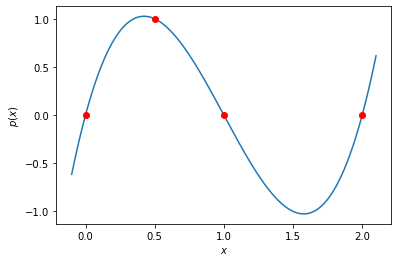

In [10]:
pN.plot()

### 19.2 Spectral clustering

We make first a general import as stated in Chapter 1 of the book:

In [11]:
from numpy import *
from matplotlib.pyplot import *

In [12]:
import scipy.linalg as sl

# create some data points
n = 100
x1 = 1.2 * random.randn(n, 2)
x2 = 0.8 * random.randn(n, 2) + tile([7, 0],(n, 1))
x = vstack((x1, x2))

# pairwise distance matrix
M = array([[ sqrt(sum((x[i] - x[j])**2)) 
             for i in range(2*n)]
             for j in range(2 * n)])
 
# create the Laplacian matrix
D = diag(1 / sqrt( M.sum(axis = 0) ))
L = identity(2 * n) - dot(D, dot(M, D))

# compute eigenvectors of L
S, V = sl.eig(L)
# As L is symmetric the imaginary parts
# in the eigenvalues are only due to negligible numerical errors S=S.real
V=V.real

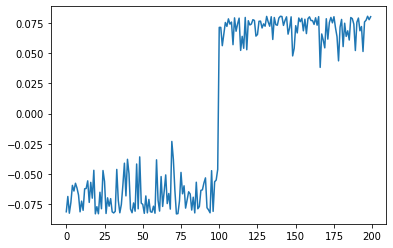

In [13]:
largest=abs(S).argmax()
plot(V[:,largest])

In [14]:
import scipy.linalg as sl
import scipy.cluster.vq as sc
# simple 4 class data
x = random.rand(1000,2)
ndx = ((x[:,0] < 0.4) | (x[:,0] > 0.6)) & \
                     ((x[:,1] < 0.4) | (x[:,1] > 0.6))
x = x[ndx]
n = x.shape[0]

# pairwise distance matrix
M = array([[ sqrt(sum((x[i]-x[j])**2)) for i in range(n) ]
           for j in range(n)])

# create the Laplacian matrix
D = diag(1 / sqrt( M.sum(axis=0) ))
L = identity(n) - dot(D, dot(M, D))

# compute eigenvectors of L
_,_,V = sl.svd(L)

k = 4
# take k first eigenvectors
eigv = V[:k,:].T

# k-means
centroids,dist = sc.kmeans(eigv,k)
clust_id = sc.vq(eigv,centroids)[0]

In [15]:
U, S, V = sl.svd(L)

In [16]:
_, _, V = sl.svd(L)

(-0.049801750201078965,
 1.047072827084997,
 -0.048309223444787386,
 1.0480372281205723)

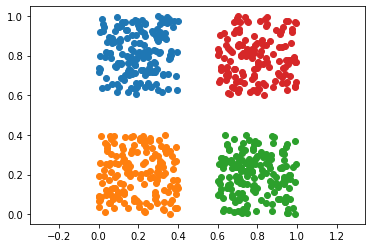

In [17]:
for i in range(k):
    ndx = where(clust_id == i)[0]
    plot(x[ndx, 0], x[ndx, 1],'o')
axis('equal')

Note, the plot above needs not to be identical to that presented in the book as it is generated from random data.

### 19.3 Solving initial value problems

In [18]:
class IV_Problem:
    """
    Initial value problem (IVP) class
    """
    def __init__(self, rhs, y0, interval, name='IVP'):
        """
        rhs 'right hand side' function of the ordinary differential
                                                   equation f(t,y)
        y0 array with initial values
        interval start and end value of the interval of independent
        variables often initial and end time
        name descriptive name of the problem
        """
        self.rhs = rhs
        self.y0 = y0
        self.t0, self.tend = interval
        self.name = name

In [19]:
def rhs(t,y):
    g = 9.81
    l = 1.
    yprime = array([y[1], g / l * sin(y[0])])
    return yprime
 
pendulum = IV_Problem(rhs, array([pi / 2, 0.]), [0., 10.] ,
                      'mathem. pendulum')

In [20]:
class IVPsolver:
    """
    IVP solver class for explicit one-step discretization methods
    with constant step size
    """
    def __init__(self, problem, discretization, stepsize):
        self.problem = problem
        self.discretization = discretization
        self.stepsize = stepsize
    def one_stepper(self):
        yield self.problem.t0, self.problem.y0
        ys = self.problem.y0
        ts = self.problem.t0
        while ts <= self.problem.tend:
            ts, ys = self.discretization(self.problem.rhs, ts, ys,
                                         self.stepsize)
            yield ts, ys
    def solve(self):
        return list(self.one_stepper())

In [21]:
def expliciteuler(rhs, ts, ys, h):
        return ts + h, ys + h * rhs(ts, ys)
def rungekutta4(rhs, ts, ys, h):
        k1 = h * rhs(ts, ys)
        k2 = h * rhs(ts + h/2., ys + k1/2.) 
        k3 = h * rhs(ts + h/2., ys + k2/2.)
        k4 = h * rhs(ts + h, ys + k3)
        return ts + h, ys + (k1 + 2*k2 + 2*k3 + k4)/6.

In [22]:
pendulum_Euler = IVPsolver(pendulum, expliciteuler, 0.001) 
pendulum_RK4 = IVPsolver(pendulum, rungekutta4, 0.001)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3a2b2d26d0>,
 Text(0.5, 1.0, 'Difference between both methods'),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Angle and angular velocity'))

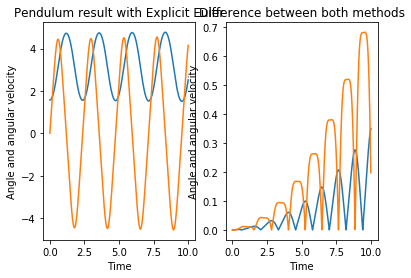

In [23]:
sol_Euler = pendulum_Euler.solve()
sol_RK4 = pendulum_RK4.solve()
tEuler, yEuler = zip(*sol_Euler)
tRK4, yRK4 = zip(*sol_RK4)
subplot(1,2,1), plot(tEuler,yEuler),\
        title('Pendulum result with Explicit Euler'),\
        xlabel('Time'), ylabel('Angle and angular velocity')
subplot(1,2,2), plot(tRK4,abs(array(yRK4)-array(yEuler))),\
        title('Difference between both methods'),\
        xlabel('Time'), ylabel('Angle and angular velocity')